In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ..

C:\Yellow Taxi Project\SimpleOps\project


## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
import joblib
from tqdm import tqdm
import yaml

## Config

## Reading Data

In [4]:
import yaml
import pprint
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

pprint.pprint(config)

{'base': {'random_seed': 42},
 'data': {'null_handled_data_csv': 'data/processed/yellow_tripdata_2023-01_null_handled.csv',
          'processed_data_csv': 'data/processed/yellow_tripdata_2023-01.csv',
          'raw_data_csv': 'data/raw/yellow_tripdata_2023-01.csv',
          'raw_data_parquet': 'data/raw/yellow_tripdata_2023-01.parquet',
          'test_size': 0.2,
          'train_data_csv': 'data/processed/train_data.csv',
          'val_data_csv': 'data/processed/val_data.csv'},
 'features': {'categorical': ['VendorID',
                              'RatecodeID',
                              'store_and_fwd_flag',
                              'payment_type',
                              'PULocationID',
                              'DOLocationID',
                              'time_of_day'],
              'numerical': ['passenger_count',
                            'trip_distance',
                            'fare_amount',
                            'extra',
                 

In [6]:
# 1. Load and preprocess data
df = pd.read_parquet('data/raw/yellow_tripdata_2023-01.parquet')
df = pd.read_parquet(config['data']['raw_data_parquet'])
df.to_csv(config['data']['raw_data_csv'])

# from src.ETL.data_load import data_load

# data_load(config_path='params.yaml')

## Fill NA Values

In [6]:
# for col in ['passenger_count', 'RatecodeID', 'congestion_surcharge', 'airport_fee']:
#     df[col] = df[col].fillna(df[col].mean())

# # Fill categorical column with mode
# for col in ['store_and_fwd_flag']:
#     df[col] = df[col].fillna(df[col].mode()[0])

# df = pd.read_csv(config['data']['raw_data_csv'])

for col in ['passenger_count', 'RatecodeID', 'congestion_surcharge', 'airport_fee']:
    df[col] = df[col].fillna(df[col].mean())

# Fill categorical column with mode
for col in ['store_and_fwd_flag']:
    df[col] = df[col].fillna(df[col].mode()[0])

# from src.ETL.null_handling import null_handling

# null_handling('params.yaml')

C:\Yellow Taxi Project\SimpleOps\project\src\ETL\null_handling.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(config['data']['raw_data_csv'])


Null handling completed and saved to CSV file successfully.


In [32]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.000000,0.97,1.00000,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.500000,0.000000
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.000000,1.10,1.00000,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.500000,0.000000
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.000000,2.51,1.00000,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.500000,0.000000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.000000,1.90,1.00000,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.000000,1.250000
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.000000,1.43,1.00000,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,1.362532,3.05,1.49744,N,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,2.274231,0.107409
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,1.362532,5.80,1.49744,N,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,2.274231,0.107409
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,1.362532,4.67,1.49744,N,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,2.274231,0.107409
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,1.362532,3.15,1.49744,N,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,2.274231,0.107409


## Feature Engineering

In [42]:
df = pd.read_csv(config['data']['null_handled_data_csv'], parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()
df = df[(df['trip_duration'] >= 60) & (df['trip_duration'] <= 7200)]

df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['is_weekend'] = df['pickup_weekday'].isin([5, 6]).astype(int)
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['month'] = df['tpep_pickup_datetime'].dt.month
df['is_peak'] = ((df['pickup_hour'].between(7,9)) | (df['pickup_hour'].between(16,18))).astype(int)

def time_of_day(hour):
    if hour < 6: return 'night'
    elif hour < 12: return 'morning'
    elif hour < 18: return 'afternoon'
    else: return 'evening'
df['time_of_day'] = df['pickup_hour'].apply(time_of_day)

categorical_cols = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
    'PULocationID', 'DOLocationID', 'time_of_day'
]
numerical_cols = [
    'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge',
    'pickup_hour', 'pickup_weekday', 'is_weekend', 'pickup_day', 'month', 'is_peak', 'manhattan_dist'
]
numerical_cols = [col for col in numerical_cols if col in df.columns]
config['features'] = config.get('features', {})  # ensure 'features' section exists
config['features']['numerical'] = numerical_cols
config['features']['categorical'] = categorical_cols
# Label encode categoricals
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.to_csv(config['data']['processed_data_csv'],index = False)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,airport_fee,trip_duration,pickup_hour,pickup_weekday,is_weekend,pickup_day,month,is_peak,time_of_day
0,1,2023-01-01 00:32:10,2023-01-01 00:40:36,-0.409408,-0.011604,0,0,65,44,2,...,0.285312,0.000000,506.0,-2.452327,1.505832,1.579878,-1.771856,-0.003078,-0.673582,3
1,1,2023-01-01 00:55:08,2023-01-01 01:01:27,-0.409408,-0.011086,0,0,197,149,1,...,0.285312,0.000000,379.0,-2.452327,1.505832,1.579878,-1.771856,-0.003078,-0.673582,3
2,1,2023-01-01 00:25:04,2023-01-01 00:37:49,-0.409408,-0.005470,0,0,202,150,1,...,0.285312,0.000000,765.0,-2.452327,1.505832,1.579878,-1.771856,-0.003078,-0.673582,3
3,0,2023-01-01 00:03:48,2023-01-01 00:13:25,-1.539317,-0.007900,0,0,39,228,1,...,-3.119026,1.250000,577.0,-2.452327,1.505832,1.579878,-1.771856,-0.003078,-0.673582,3
4,1,2023-01-01 00:10:29,2023-01-01 00:21:19,-0.409408,-0.009772,0,0,6,238,1,...,0.285312,0.000000,650.0,-2.452327,1.505832,1.579878,-1.771856,-0.003078,-0.673582,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,1,2023-01-31 23:58:34,2023-02-01 00:12:33,0.000220,-0.003320,1,0,6,204,0,...,-0.022126,0.107409,839.0,1.537137,-1.007257,-0.632960,1.676428,-0.003078,-0.673582,1
3066762,1,2023-01-31 23:31:09,2023-01-31 23:50:36,0.000220,0.007632,1,0,11,234,0,...,-0.022126,0.107409,1167.0,1.537137,-1.007257,-0.632960,1.676428,-0.003078,-0.673582,1
3066763,1,2023-01-31 23:01:05,2023-01-31 23:25:36,0.000220,0.003132,1,0,13,151,0,...,-0.022126,0.107409,1471.0,1.537137,-1.007257,-0.632960,1.676428,-0.003078,-0.673582,1
3066764,1,2023-01-31 23:40:00,2023-01-31 23:53:00,0.000220,-0.002922,1,0,141,238,0,...,-0.022126,0.107409,780.0,1.537137,-1.007257,-0.632960,1.676428,-0.003078,-0.673582,1


In [7]:
from src.ETL.featurize import featurize

featurize('params.yaml')

Featurization completed and saved to CSV file successfully.


## Train Test Split

In [11]:
df = pd.read_csv(config['data']['processed_data_csv'])

    # Train/validation split
train_df, val_df = train_test_split(
    df,
    test_size=config['data']['test_size'],
    random_state=config['base']['random_seed']
)

# Save without index
train_df.to_csv(config['data']['train_data_csv'], index=False)
val_df.to_csv(config['data']['val_data_csv'], index=False)

In [12]:
train_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'trip_duration',
       'pickup_hour', 'pickup_weekday', 'is_weekend', 'pickup_day', 'month',
       'is_peak', 'time_of_day'],
      dtype='object')

In [8]:
from src.ETL.data_split import data_split

data_split('params.yaml')

✅ Train and validation data saved.


In [8]:
# Prepare data
X = df[categorical_cols + numerical_cols]
y = df['trip_duration'].values.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config['data']['test_size'], random_state=config['base']['random_seed'])

y_train_series = pd.Series(y_train, name='trip_duration', index=X_train.index)

# Combine X and y into one training DataFrame
train_df = pd.concat([X_train, y_train_series], axis=1)

y_val_series = pd.Series(y_val, name='trip_duration', index=X_val.index)

# Combine X and y into one training DataFrame
val_df = pd.concat([X_val, y_val_series], axis=1)

train_df.to_csv(config['data']['train_data_csv'])
val_df.to_csv(config['data']['val_data_csv'])

## 1. PyTorch Neural Network

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# ========== PyTorch Neural Network ==========
class TaxiDataset(Dataset):
    def __init__(self, X, y, categorical_cols, numerical_cols):
        self.X_cat = X[categorical_cols].values.astype(np.int64)
        self.X_num = X[numerical_cols].values.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]

df_t = pd.read_csv(config['data']['train_data_csv']) 
df_v = pd.read_csv(config['data']['val_data_csv'])

categorical_cols = config['features']['categorical']
numerical_cols = config['features']['numerical']

X_train = df_t[categorical_cols + numerical_cols]
y_train = df_t['trip_duration'].values.astype(np.float32)

X_val = df_v[categorical_cols + numerical_cols]
y_val = df_v['trip_duration'].values.astype(np.float32)

train_ds = TaxiDataset(X_train, y_train, categorical_cols, numerical_cols)
val_ds = TaxiDataset(X_val, y_val, categorical_cols, numerical_cols)
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=2048, shuffle=False, num_workers=2, pin_memory=True)

cat_dims = [int(df_t[col].nunique()) for col in categorical_cols]
emb_dims = [(x, min(50, (x+1)//2)) for x in cat_dims]

config['train']['PyNN']['cat_dims'] = cat_dims
with open('params.yaml', 'w') as f:
    yaml.safe_dump(config, f)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Print CUDA info for debugging
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

class TaxiNet(nn.Module):
    def __init__(self, emb_dims, n_num):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        emb_dim_sum = sum([y for x, y in emb_dims])
        self.fc = nn.Sequential(
            nn.Linear(emb_dim_sum + n_num, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x, x_num], 1)
        return self.fc(x).squeeze(1)

# Set device and move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TaxiNet(emb_dims, len(numerical_cols)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['train']['PyNN']['lr'])
criterion = nn.MSELoss()

# Use a reasonable batch size and num_workers=0 for debugging
BATCH_SIZE = config['train']['PyNN']['batch_size']
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=config['train']['PyNN']['num_workers'])
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=config['train']['PyNN']['num_workers'])

# Training loop with tqdm and early stopping
best_r2 = -np.inf
patience, patience_counter = config['train']['PyNN']['patience'], config['train']['PyNN']['patience_counter']
EPOCHS = config['train']['PyNN']['epochs']

for epoch in range(5):
    model.train()
    train_losses = []
    for x_cat, x_num, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x_cat, x_num, y_batch = x_cat.to(device), x_num.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_cat, x_num)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for x_cat, x_num, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            preds = model(x_cat, x_num).cpu().numpy()
            val_preds.append(preds)
            val_targets.append(y_batch.numpy())
    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)
    val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    val_r2 = r2_score(val_targets, val_preds)
    print(f"Epoch {epoch+1:02d} | Train Loss: {np.mean(train_losses):.4f} | Val RMSE: {val_rmse:.2f} | Val R2: {val_r2:.4f}")
    if val_r2 > best_r2:
        best_r2 = val_r2
        patience_counter = 0
        torch.save(model.state_dict(), config['train']['PyNN']['model_path'])
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and get predictions for stacking
model.load_state_dict(torch.load(config['train']['PyNN']['model_path']))
model.eval()

def get_nn_preds(X_df):
    ds = TaxiDataset(X_df, np.zeros(len(X_df)), categorical_cols, numerical_cols)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=config['train']['PyNN']['num_workers'])
    preds = []
    with torch.no_grad():
        for x_cat, x_num, _ in tqdm(dl, desc="Predicting"):
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            batch_preds = model(x_cat, x_num).cpu().numpy()
            preds.append(batch_preds)
    return np.concatenate(preds)

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4050 Laptop GPU


Epoch 1 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 130.21it/s]


Epoch 01 | Train Loss: 272338.6040 | Val RMSE: 331.73 | Val R2: 0.7441


Epoch 2 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 132.02it/s]


Epoch 02 | Train Loss: 39566.1444 | Val RMSE: 211.89 | Val R2: 0.8956


Epoch 3 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 128.85it/s]


Epoch 03 | Train Loss: 37792.1990 | Val RMSE: 192.84 | Val R2: 0.9135


Epoch 4 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 135.85it/s]


Epoch 04 | Train Loss: 36340.3298 | Val RMSE: 350.71 | Val R2: 0.7140


Epoch 5 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 141.66it/s]
C:\Users\Sriram\AppData\Local\Temp\ipykernel_9604\3923222400.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please op

Epoch 05 | Train Loss: 33326.8354 | Val RMSE: 221.77 | Val R2: 0.8857


In [10]:
from src.model.training.PyNN import PyNN

PyNN('params.yaml')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## 1. PyTorch Neural Network Evaluation

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# 1. Define the Dataset class (must match training)
class TaxiDataset(Dataset):
    def __init__(self, X, y, categorical_cols, numerical_cols):
        self.X_cat = X[categorical_cols].values.astype(np.int64)
        self.X_num = X[numerical_cols].values.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]

# 2. Define the model class (must match training)
class TaxiNet(nn.Module):
    def __init__(self, emb_dims, n_num):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        emb_dim_sum = sum([y for x, y in emb_dims])
        self.fc = nn.Sequential(
            nn.Linear(emb_dim_sum + n_num, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x, x_num], 1)
        return self.fc(x).squeeze(1)

# 3. The evaluation function
def evaluate_saved_model(
    config_path,
    batch_size=2048,
    
):
    with open(config_path) as f:
        config = yaml.safe_load(f)

    model_path = config['train']['PyNN']['model_path']
    df_val = pd.read_csv(config['data']['val_data_csv'])
    categorical_cols = config['features']['categorical']
    numerical_cols = config['features']['numerical']
    batch_size = config['train']['PyNN']['batch_size']

    cat_dims = config['train']['PyNN']['cat_dims']
    emb_dims = [(x, min(50, (x+1)//2)) for x in cat_dims]

    # Prepare validation dataset and loader
    X_val = df_val[categorical_cols + numerical_cols]
    y_val = df_val['trip_duration'].values.astype(np.float32)
    val_ds = TaxiDataset(X_val, y_val, categorical_cols, numerical_cols)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    # Instantiate and load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TaxiNet(emb_dims, len(numerical_cols)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Run evaluation
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for x_cat, x_num, y_batch in tqdm(val_loader, desc="Evaluating"):
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            preds = model(x_cat, x_num).cpu().numpy()
            val_preds.append(preds)
            val_targets.append(y_batch.numpy())
    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)

    # Remove NaNs
    mask = ~np.isnan(val_preds) & ~np.isnan(val_targets)
    val_preds = val_preds[mask]
    val_targets = val_targets[mask]

    rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    r2 = r2_score(val_targets, val_preds)
    print(f"PyTorch NN - RMSE: {rmse:.2f}, R²: {r2:.4f}")
    return rmse, r2, val_preds, val_targets


In [1]:
%cd ..

C:\Yellow Taxi Project\SimpleOps\project


In [ ]:
from src.eval.PyNN_eval import PyNN_eval

PyNN_eval('params.yaml')

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# After training and loading best model weights
model.load_state_dict(torch.load(config['train']['PyNN']['model_path']))
model.eval()

# Get predictions on validation set
val_preds = []
val_targets = []
with torch.no_grad():
    for x_cat, x_num, y_batch in val_loader:
        x_cat, x_num = x_cat.to(device), x_num.to(device)
        preds = model(x_cat, x_num).cpu().numpy()
        val_preds.append(preds)
        val_targets.append(y_batch.numpy())
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Remove any NaNs just in case
mask = ~np.isnan(val_preds) & ~np.isnan(val_targets)
val_preds = val_preds[mask]
val_targets = val_targets[mask]

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
r2 = r2_score(val_targets, val_preds)
print(f"PyTorch NN - RMSE: {rmse:.2f}, R²: {r2:.4f}")


In [19]:
eval_pynn('params.yaml')

C:\Users\Sriram\AppData\Local\Temp\ipykernel_103336\3698554473.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['train']['PyNN'][

RuntimeError: Error(s) in loading state_dict for TaxiNet:
	size mismatch for embeddings.4.weight: copying a param with shape torch.Size([256, 50]) from checkpoint, the shape in current model is torch.Size([245, 50]).
	size mismatch for embeddings.5.weight: copying a param with shape torch.Size([261, 50]) from checkpoint, the shape in current model is torch.Size([259, 50]).

## XGBoost

In [19]:
!pip show xgboost

Name: xgboost
Version: 3.0.1
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: C:\Users\Sriram\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages
Requires: numpy, scipy
Required-by: 


In [18]:
# ========== XGBoost with GPU ==========
df_t = pd.read_csv(config['data']['train_data_csv']) 
df_v = pd.read_csv(config['data']['val_data_csv'])

categorical_cols = config['features']['categorical']
numerical_cols = config['features']['numerical']

X_train = df_t[categorical_cols + numerical_cols]
y_train = df_t['trip_duration'].values.astype(np.float32)
X_val = df_v[categorical_cols + numerical_cols]
y_val = df_v['trip_duration'].values.astype(np.float32)

xgb_model = xgb.XGBRegressor(
    tree_method=config['train']['XGBoost']['tree_method'],
    device = config['train']['XGBoost']['device'],
    n_estimators=config['train']['XGBoost']['n_estimators'],
    max_depth=config['train']['XGBoost']['max_depth'],
    learning_rate=config['train']['XGBoost']['learning_rate'],
    subsample=config['train']['XGBoost']['subsample'],
    colsample_bytree=config['train']['XGBoost']['colsample_bytree'],
    objective=config['train']['XGBoost']['objective'],
    random_state=config['train']['XGBoost']['random_state'],
    early_stopping_rounds=config['train']['XGBoost']['early_stopping_rounds']
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)#

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
df_t.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,congestion_surcharge,airport_fee,trip_duration,pickup_hour,pickup_weekday,is_weekend,pickup_day,month,is_peak,time_of_day
count,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,...,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06,2.424060e+06
mean,7.293706e-01,3.995065e-04,-2.392134e-04,1.444845e-01,6.413208e-03,1.104124e+02,1.206445e+02,1.184875e+00,-1.824559e-05,-8.247045e-05,...,2.021982e-04,1.070408e-01,8.753561e+02,-2.913456e-04,-3.244128e-04,-1.500749e-04,-2.272624e-04,-6.134643e-05,3.144599e-04,1.009869e+00
std,4.442851e-01,1.000093e+00,8.631904e-01,6.283641e-01,7.982532e-02,6.785001e+01,6.875107e+01,5.127912e-01,9.992779e-01,9.992729e-01,...,9.996173e-01,3.499012e-01,6.574866e+02,9.999558e-01,1.000213e+00,9.999291e-01,9.998132e-01,9.889317e-01,1.000128e+00,9.576873e-01
min,0.000000e+00,-1.539317e+00,-1.546687e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.488557e+01,-5.057576e+00,...,-6.523364e+00,-1.250000e+00,6.000000e+01,-2.452327e+00,-1.509875e+00,-6.329604e-01,-1.771856e+00,-3.077546e-03,-6.735825e-01,0.000000e+00
25%,0.000000e+00,-4.094081e-01,-1.112578e-02,0.000000e+00,0.000000e+00,4.400000e+01,6.200000e+01,1.000000e+00,-5.649178e-01,-8.654199e-01,...,2.853115e-01,0.000000e+00,4.350000e+02,-7.177773e-01,-1.007257e+00,-6.329604e-01,-8.523135e-01,-3.077546e-03,-6.735825e-01,0.000000e+00
50%,1.000000e+00,-4.094081e-01,-8.298102e-03,0.000000e+00,0.000000e+00,1.200000e+02,1.420000e+02,1.000000e+00,-3.200201e-01,-3.064657e-01,...,2.853115e-01,0.000000e+00,6.970000e+02,1.494975e-01,-2.021536e-03,-6.329604e-01,6.722883e-02,-3.077546e-03,-6.735825e-01,1.000000e+00
75%,1.000000e+00,-4.094081e-01,-2.045345e-03,0.000000e+00,0.000000e+00,1.500000e+02,1.620000e+02,1.000000e+00,1.021368e-01,5.319656e-01,...,2.853115e-01,0.000000e+00,1.102000e+03,8.433173e-01,1.003214e+00,1.579878e+00,8.718284e-01,-3.077546e-03,1.484599e+00,2.000000e+00
max,1.000000e+00,7.499955e+00,9.000125e+02,6.000000e+00,1.000000e+00,2.550000e+02,2.600000e+02,4.000000e+00,5.718428e+01,6.121508e+00,...,2.853115e-01,1.250000e+00,7.199000e+03,1.537137e+00,1.505832e+00,1.579878e+00,1.676428e+00,3.407848e+02,1.484599e+00,3.000000e+00


In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on validation set
booster = xgb_model.get_booster()
dval = xgb.DMatrix(X_val)
y_pred = booster.predict(dval)
# y_pred = xgb_model.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Compute R² score
r2 = r2_score(y_val, y_pred)

print(f"XGBoost (GPU) - RMSE: {rmse:.2f}, R²: {r2:.4f}")

XGBoost (GPU) - RMSE: 146.63, R²: 0.9500


## LightGBM

In [16]:
# ========== LightGBM with GPU ==========
df_t = pd.read_csv(config['data']['train_data_csv']) 
df_v = pd.read_csv(config['data']['val_data_csv'])

categorical_cols = config['features']['categorical']
numerical_cols = config['features']['numerical']

X_train = df_t[categorical_cols + numerical_cols]
y_train = df_t['trip_duration'].values.astype(np.float32)
X_val = df_v[categorical_cols + numerical_cols]
y_val = df_v['trip_duration'].values.astype(np.float32)

lgb_model = lgb.LGBMRegressor(
    device=config['train']['LightGBM']['device'],
    num_leaves=config['train']['LightGBM']['num_leaves'],
    learning_rate=config['train']['LightGBM']['learning_rate'],
    n_estimators=config['train']['LightGBM']['n_estimators'],
    min_child_samples=config['train']['LightGBM']['min_child_samples'],
    early_stopping_rounds=config['train']['LightGBM']['early_stopping_rounds'],
    random_state=config['train']['LightGBM']['random_state'],
    verbose = 0
)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20


LGBMRegressor(device='gpu', early_stopping_rounds=20, learning_rate=0.05,
              n_estimators=500, random_state=42, verbose=0)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on validation set
y_pred = lgb_model.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Compute R² score
r2 = r2_score(y_val, y_pred)

print(f"LGB_Model (GPU) - RMSE: {rmse:.2f}, R²: {r2:.4f}")

LGB_Model (GPU) - RMSE: 155.88, R²: 0.9435


## Plot

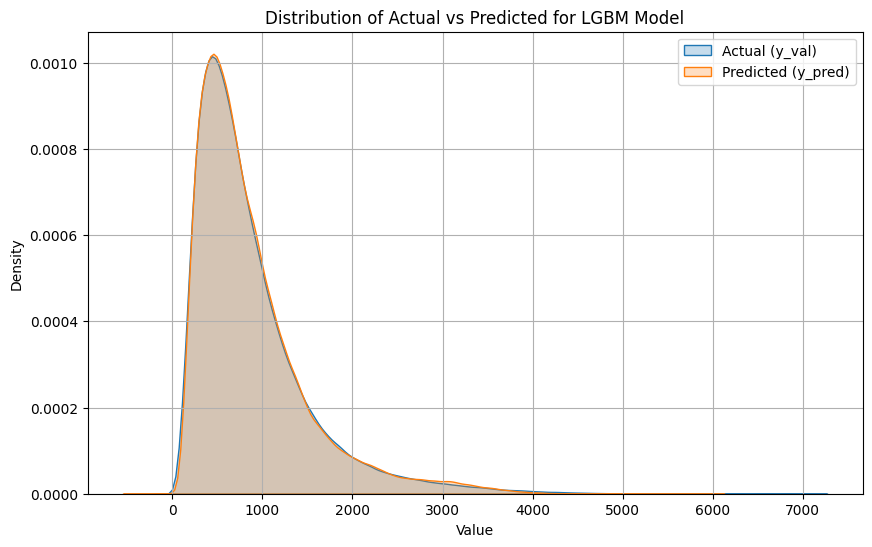

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_val and y_pred are lists, Series, or arrays
df = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})

plt.figure(figsize=(10, 6))
sns.kdeplot(df['y_val'], label='Actual (y_val)', fill=True)
sns.kdeplot(df['y_pred'], label='Predicted (y_pred)', fill=True)
plt.title('Distribution of Actual vs Predicted for LGBM Model')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.savefig(config['reports']['kde']['lgbm'])
plt.show()

## TabNet Regressor

In [19]:
from pytorch_tabnet.tab_model import TabNetRegressor

tabnet = TabNetRegressor(device_name='cuda' if torch.cuda.is_available() else 'cpu')
tabnet.fit(
    X_train.values, y_train.reshape(-1, 1),
    eval_set=[(X_val.values, y_val.reshape(-1, 1))],
    eval_metric=config['train']['TabNet']['eval_metric'],
    max_epochs=config['train']['TabNet']['max_epochs'],
    patience=config['train']['TabNet']['patience'],
    batch_size=config['train']['TabNet']['batch_size'],
    virtual_batch_size=config['train']['TabNet']['virtual_batch_size'],
    num_workers=config['train']['TabNet']['num_workers']
)
tabnet_pred = tabnet.predict(X_val.values).squeeze()
print(f"TabNet RMSE: {np.sqrt(mean_squared_error(y_val, tabnet_pred)):.2f}, R²: {r2_score(y_val, tabnet_pred):.4f}")


C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 94662.62751| val_0_rmse: 451.44665|  0:01:29s
epoch 1  | loss: 37360.98076| val_0_rmse: 500.14762|  0:03:05s
epoch 2  | loss: 35678.4722| val_0_rmse: 525.99275|  0:04:38s
epoch 3  | loss: 34427.55769| val_0_rmse: 410.25369|  0:06:07s
epoch 4  | loss: 33619.74903| val_0_rmse: 486.03792|  0:07:53s
epoch 5  | loss: 33107.3023| val_0_rmse: 451.52838|  0:09:51s
epoch 6  | loss: 32718.9395| val_0_rmse: 457.33479|  0:11:44s
epoch 7  | loss: 32355.39965| val_0_rmse: 451.68865|  0:13:35s
epoch 8  | loss: 32061.71177| val_0_rmse: 498.66986|  0:15:18s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 410.25369


C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet RMSE: 410.25, R²: 0.6087


## Ridge, Lasso, ElasticNet Regressor

In [20]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Ridge Regression
ridge = Ridge(alpha=config['train']['LReg']['Ridge']['alpha'], random_state=config['base']['random_seed'])
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_val)
print(f"Ridge RMSE: {np.sqrt(mean_squared_error(y_val, ridge_pred)):.2f}, R²: {r2_score(y_val, ridge_pred):.4f}")

# Lasso Regression
lasso = Lasso(alpha=config['train']['LReg']['Lasso']['alpha'], random_state=config['base']['random_seed'], max_iter=config['train']['LReg']['Lasso']['max_iter'])
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_val)
print(f"Lasso RMSE: {np.sqrt(mean_squared_error(y_val, lasso_pred)):.2f}, R²: {r2_score(y_val, lasso_pred):.4f}")

# ElasticNet Regression
enet = ElasticNet(alpha=config['train']['LReg']['ElasticNet']['alpha'], l1_ratio=config['train']['LReg']['ElasticNet']['l1_ratio'], random_state=config['base']['random_seed'], max_iter=config['train']['LReg']['ElasticNet']['max_iter'])
enet.fit(X_train, y_train)
enet_pred = enet.predict(X_val)
print(f"ElasticNet RMSE: {np.sqrt(mean_squared_error(y_val, enet_pred)):.2f}, R²: {r2_score(y_val, enet_pred):.4f}")


Ridge RMSE: 358.04, R²: 0.7019
Lasso RMSE: 358.00, R²: 0.7020
ElasticNet RMSE: 349.55, R²: 0.7159


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def generate_kde_plot(y_val, y_pred, model_name: str, save_path: str):
    """
    Generates and saves a KDE plot comparing actual and predicted values.

    Parameters:
    - y_val: array-like of true values
    - y_pred: array-like of predicted values
    - model_name: string, name of the ML model (used in plot title)
    - save_path: string, path to save the generated plot
    """
    df = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})

    plt.figure(figsize=(10, 6))
    sns.kdeplot(df['y_val'], label='Actual (y_val)', fill=True, common_norm=False)
    sns.kdeplot(df['y_pred'], label='Predicted (y_pred)', fill=True, common_norm=False)
    plt.title(f'Distribution of Actual vs Predicted for {model_name} Model')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    plt.savefig(save_path)
    plt.close()  # Avoid overlap when plotting multiple figures

generate_kde_plot(y_val, enet_pred, model_name=enet, save_path='enet_g.jpg')